In [ ]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib import style
style.use('ggplot')
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#data preprocessing

df.sentiment.replace('positive', 1, inplace=True)
df.sentiment.replace('negative', 0, inplace=True)

def data_processing(text):
    text= text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text_tokens = word_tokenize(text)
    filtered_text = [w for w in text_tokens if not w in stop_words]
    return " ".join(filtered_text)

def data_processing_absa(text):
    text = text.lower()
    text = re.sub('<br />', '', text)
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'\\','',text)

    return text

df['absa_review'] = df['review'].apply(data_processing_absa)
df = df.drop_duplicates('absa_review')

df.review = df['review'].apply(data_processing)

duplicated_count = df.duplicated().sum()

df = df.drop_duplicates('review')

stemmer = PorterStemmer()
def stemming(data):
    text = [stemmer.stem(word) for word in data]
    return data

df.review = df['review'].apply(lambda x: stemming(x))

<ipython-input-3-a976b1911656>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.sentiment.replace('positive', 1, inplace=True)
<ipython-input-3-a976b1911656>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
X = df['review']
y = df['sentiment']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Testing set size: {len(X_test)}")

Training set size: 34704
Validation set size: 7437
Testing set size: 7437


In [ ]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
## logistic regression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, lr_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))
print(classification_report(y_val, lr_pred))

Val accuracy: 89.08%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3615
           1       0.89      0.90      0.89      3822

    accuracy                           0.89      7437
   macro avg       0.89      0.89      0.89      7437
weighted avg       0.89      0.89      0.89      7437



In [ ]:
lr_test_pred = lr.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, lr_test_pred)
print("Test accuracy: {:.2f}%".format(test_accuracy*100))
print(classification_report(y_test, lr_test_pred))

Test accuracy: 89.10%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3746
           1       0.88      0.90      0.89      3691

    accuracy                           0.89      7437
   macro avg       0.89      0.89      0.89      7437
weighted avg       0.89      0.89      0.89      7437



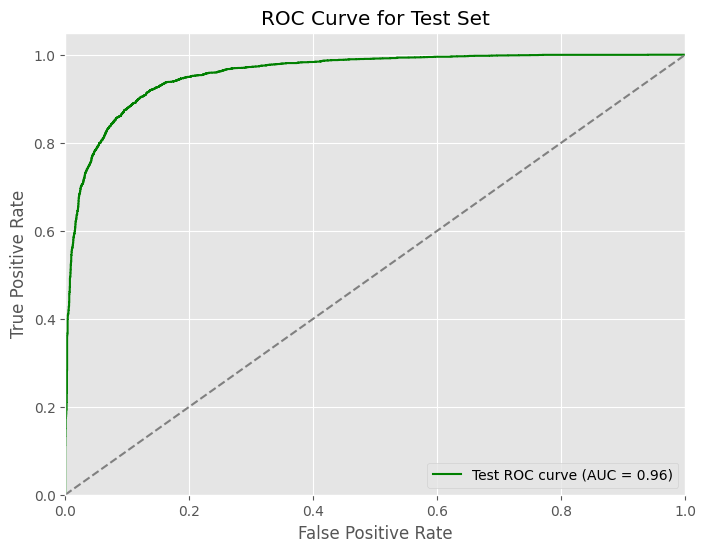

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Predict probabilities on the test set
y_test_prob = lr.predict_proba(X_test_tfidf)[:, 1]  # For the positive class

# Calculate ROC curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# naive bayes
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, nb_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))
print(classification_report(y_val, nb_pred))

Val accuracy: 86.43%
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      3615
           1       0.87      0.86      0.87      3822

    accuracy                           0.86      7437
   macro avg       0.86      0.86      0.86      7437
weighted avg       0.86      0.86      0.86      7437



In [ ]:
nb_test_pred = nb.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, nb_test_pred)
print("Test accuracy: {:.2f}%".format(test_accuracy*100))
print(classification_report(y_test, nb_test_pred))

Test accuracy: 86.42%
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      3746
           1       0.87      0.85      0.86      3691

    accuracy                           0.86      7437
   macro avg       0.86      0.86      0.86      7437
weighted avg       0.86      0.86      0.86      7437



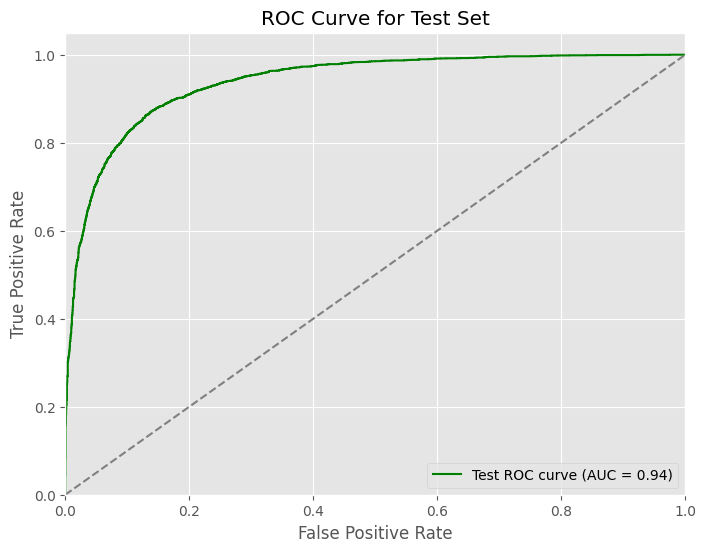

In [ ]:
# Predict probabilities on the test set
y_test_prob = nb.predict_proba(X_test_tfidf)[:, 1]  # For the positive class

# Calculate ROC curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_tfidf, y_train)
knn_pred = knn.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, knn_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))
print(classification_report(y_val, knn_pred))

Val accuracy: 76.27%
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      3615
           1       0.74      0.83      0.78      3822

    accuracy                           0.76      7437
   macro avg       0.77      0.76      0.76      7437
weighted avg       0.77      0.76      0.76      7437



In [ ]:
knn_test_pred = knn.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, knn_test_pred)
print("Test accuracy: {:.2f}%".format(test_accuracy*100))
print(classification_report(y_test, knn_test_pred))

Test accuracy: 78.03%
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      3746
           1       0.75      0.85      0.79      3691

    accuracy                           0.78      7437
   macro avg       0.79      0.78      0.78      7437
weighted avg       0.79      0.78      0.78      7437



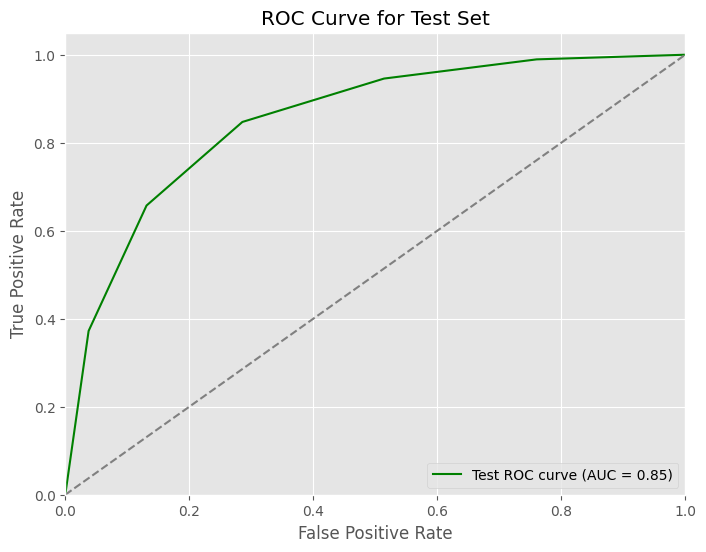

In [ ]:
# Predict probabilities on the test set
y_test_prob = knn.predict_proba(X_test_tfidf)[:, 1]  # For the positive class

# Calculate ROC curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Linear SVC
lsvc = LinearSVC()
lsvc.fit(X_train_tfidf, y_train)
lsvc_pred = lsvc.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, lsvc_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))
print(classification_report(y_val, lsvc_pred))

Val accuracy: 89.26%
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3615
           1       0.89      0.90      0.90      3822

    accuracy                           0.89      7437
   macro avg       0.89      0.89      0.89      7437
weighted avg       0.89      0.89      0.89      7437



In [ ]:
lsvc_test_pred = lsvc.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, lsvc_test_pred)
print("Test accuracy: {:.2f}%".format(test_accuracy*100))
print(classification_report(y_test, lsvc_test_pred))

Test accuracy: 89.18%
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3746
           1       0.88      0.90      0.89      3691

    accuracy                           0.89      7437
   macro avg       0.89      0.89      0.89      7437
weighted avg       0.89      0.89      0.89      7437



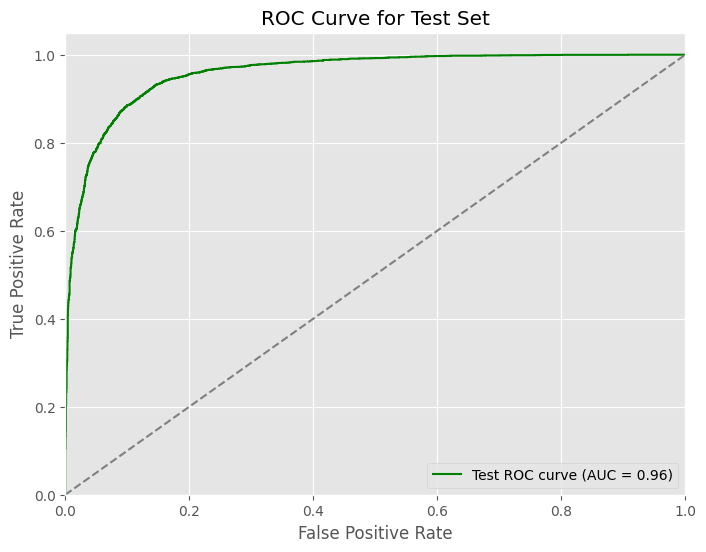

In [ ]:
# Predict probabilities on the test set
y_test_prob = lsvc.decision_function(X_test_tfidf)

# Calculate ROC curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# XGB
xgb = XGBClassifier()
xgb.fit(X_train_tfidf, y_train)
xgb_pred = xgb.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, xgb_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))

Val accuracy: 85.88%


In [ ]:
print(classification_report(y_val, xgb_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3615
           1       0.85      0.88      0.87      3822

    accuracy                           0.86      7437
   macro avg       0.86      0.86      0.86      7437
weighted avg       0.86      0.86      0.86      7437



In [ ]:
xgb_test_pred = xgb.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, xgb_test_pred)
print("Test accuracy: {:.2f}%".format(test_accuracy*100))
print(classification_report(y_test, xgb_test_pred))

Test accuracy: 85.30%
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      3746
           1       0.84      0.88      0.86      3691

    accuracy                           0.85      7437
   macro avg       0.85      0.85      0.85      7437
weighted avg       0.85      0.85      0.85      7437



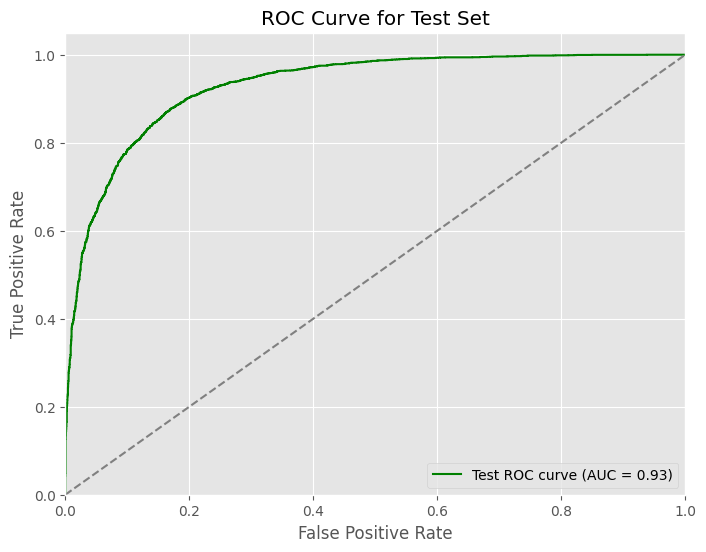

In [ ]:
# Predict probabilities on the test set
y_test_prob = xgb.predict_proba(X_test_tfidf)[:, 1]  # For the positive class

# Calculate ROC curve for test set
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for test set
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# # logistic regression using cross validation
# lr_cv = LogisticRegressionCV(cv=10, max_iter=1000)
# lr_cv.fit(X_train_tfidf, y_train)
# lr_cv_pred = lr_cv.predict(X_val_tfidf)
# val_accuracy = accuracy_score(y_val, lr_cv_pred)
# print("Val accuracy: {:.2f}%".format(val_accuracy*100))
# print(classification_report(y_val, lr_cv_pred))

In [ ]:
# lr_cv_test_pred = lr_cv.predict(X_test_tfidf)
# test_accuracy = accuracy_score(y_test, lr_cv_test_pred)
# print("Test accuracy: {:.2f}%".format(test_accuracy*100))
# print(classification_report(y_test, lr_cv_test_pred))

In [ ]:
# # Predict probabilities on the test set
# y_test_prob = lr_cv.predict_proba(X_test_tfidf)[:, 1]  # For the positive class

# # Calculate ROC curve for test set
# fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
# roc_auc_test = auc(fpr_test, tpr_test)

# # Plot ROC curve for test set
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Test Set')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C':[0.1, 1, 10, 100], 'loss':['hinge', 'squared_hinge']}
grid = GridSearchCV(lsvc, param_grid, refit=True, verbose = 3)
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .................C=0.1, loss=hinge;, score=0.873 total time=   0.2s
[CV 2/5] END .................C=0.1, loss=hinge;, score=0.875 total time=   0.2s
[CV 3/5] END .................C=0.1, loss=hinge;, score=0.871 total time=   0.2s
[CV 4/5] END .................C=0.1, loss=hinge;, score=0.878 total time=   0.2s
[CV 5/5] END .................C=0.1, loss=hinge;, score=0.874 total time=   0.2s
[CV 1/5] END .........C=0.1, loss=squared_hinge;, score=0.892 total time=   0.3s
[CV 2/5] END .........C=0.1, loss=squared_hinge;, score=0.895 total time=   0.3s
[CV 3/5] END .........C=0.1, loss=squared_hinge;, score=0.887 total time=   0.3s
[CV 4/5] END .........C=0.1, loss=squared_hinge;, score=0.893 total time=   0.3s
[CV 5/5] END .........C=0.1, loss=squared_hinge;, score=0.890 total time=   0.3s
[CV 1/5] END ...................C=1, loss=hinge;, score=0.895 total time=   0.6s
[CV 2/5] END ...................C=1, loss=hinge;,

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END ..................C=10, loss=hinge;, score=0.875 total time=  20.0s
[CV 4/5] END ..................C=10, loss=hinge;, score=0.881 total time=   4.4s
[CV 5/5] END ..................C=10, loss=hinge;, score=0.878 total time=   5.3s
[CV 1/5] END ..........C=10, loss=squared_hinge;, score=0.880 total time=   1.7s
[CV 2/5] END ..........C=10, loss=squared_hinge;, score=0.885 total time=   1.9s
[CV 3/5] END ..........C=10, loss=squared_hinge;, score=0.879 total time=   2.1s
[CV 4/5] END ..........C=10, loss=squared_hinge;, score=0.885 total time=   2.4s
[CV 5/5] END ..........C=10, loss=squared_hinge;, score=0.882 total time=   2.8s
[CV 1/5] END .................C=100, loss=hinge;, score=0.875 total time=   2.8s
[CV 2/5] END .................C=100, loss=hinge;, score=0.880 total time=   8.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/5] END .................C=100, loss=hinge;, score=0.874 total time=  10.7s
[CV 4/5] END .................C=100, loss=hinge;, score=0.880 total time=   4.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END .................C=100, loss=hinge;, score=0.878 total time=  10.2s
[CV 1/5] END .........C=100, loss=squared_hinge;, score=0.876 total time=   3.2s
[CV 2/5] END .........C=100, loss=squared_hinge;, score=0.881 total time=   6.9s
[CV 3/5] END .........C=100, loss=squared_hinge;, score=0.875 total time=  10.6s
[CV 4/5] END .........C=100, loss=squared_hinge;, score=0.880 total time=   7.5s
[CV 5/5] END .........C=100, loss=squared_hinge;, score=0.878 total time=   7.0s


GridSearchCV(estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge']},
             verbose=3)

In [ ]:
lsvc = LinearSVC(C = 1, loss='hinge')
lsvc.fit(X_train_tfidf, y_train)
lsvc_pred = lsvc.predict(X_test_tfidf)
lsvc_acc = accuracy_score(lsvc_pred, y_test)
print("Test accuracy: {:.2f}%".format(lsvc_acc*100))

Test accuracy: 89.26%


In [ ]:
lsvc_val_pred = lsvc.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, lsvc_val_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))

Val accuracy: 89.46%


In [ ]:
# for nb
param_grid = {'alpha':[0.1, 1, 10, 100]}
grid = GridSearchCV(nb, param_grid, refit=True, verbose = 3)
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .........................alpha=0.1;, score=0.860 total time=   0.1s
[CV 2/5] END .........................alpha=0.1;, score=0.862 total time=   0.1s
[CV 3/5] END .........................alpha=0.1;, score=0.860 total time=   0.1s
[CV 4/5] END .........................alpha=0.1;, score=0.859 total time=   0.1s
[CV 5/5] END .........................alpha=0.1;, score=0.857 total time=   0.1s
[CV 1/5] END ...........................alpha=1;, score=0.864 total time=   0.1s
[CV 2/5] END ...........................alpha=1;, score=0.867 total time=   0.1s
[CV 3/5] END ...........................alpha=1;, score=0.865 total time=   0.1s
[CV 4/5] END ...........................alpha=1;, score=0.865 total time=   0.1s
[CV 5/5] END ...........................alpha=1;, score=0.861 total time=   0.1s
[CV 1/5] END ..........................alpha=10;, score=0.855 total time=   0.1s
[CV 2/5] END ..........................alpha=10;,

GridSearchCV(estimator=MultinomialNB(), param_grid={'alpha': [0.1, 1, 10, 100]},
             verbose=3)

In [ ]:
nb = MultinomialNB(alpha=1)
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)
nb_acc = accuracy_score(nb_pred, y_test)
print("Test accuracy: {:.2f}%".format(nb_acc*100))

Test accuracy: 86.42%


In [ ]:
nb_val_pred = nb.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, nb_val_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))

Val accuracy: 86.43%


In [ ]:
#for lr
param_grid = {'C':[0.1, 1, 10, 100], 'penalty':['l1', 'l2']}
grid = GridSearchCV(lr, param_grid, refit=True, verbose = 3)
grid.fit(X_train_tfidf, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.863 total time=   1.0s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.861 total time=   1.2s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.859 total time=   2.5s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.865 total time=   1.8s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.859 total time=   0.8s
[CV 1/5] END .....................C=1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .....................C=1, penalty=l1

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1194, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/us

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
             verbose=3)

In [ ]:
lr = LogisticRegression(C=10)
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)
lr_acc = accuracy_score(lr_pred, y_test)
print("Test accuracy: {:.2f}%".format(lr_acc*100))

Test accuracy: 89.32%


In [ ]:
lr_val_pred = lr.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, lr_val_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))

Val accuracy: 89.32%


In [ ]:
# Define ensemble model with voting
ensemble_model = VotingClassifier(
    estimators=[('lr',lr),('lsvc',lsvc),('nb',nb)],
    voting='hard'  # 'hard' uses majority voting; 'soft' uses predicted probabilities for averaging
)

In [ ]:
ensemble_model.fit(X_train_tfidf, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10)),
                             ('lsvc', LinearSVC(C=1, loss='hinge')),
                             ('nb', MultinomialNB(alpha=1))])

In [ ]:
# Predict on validation set
y_val_pred = ensemble_model.predict(X_val_tfidf)

# Calculate accuracy and classification report
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Val accuracy: {:.2f}%".format(val_accuracy*100))
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Val accuracy: 89.71%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      3615
           1       0.90      0.91      0.90      3822

    accuracy                           0.90      7437
   macro avg       0.90      0.90      0.90      7437
weighted avg       0.90      0.90      0.90      7437



In [ ]:
# Predict on test set
y_test_pred = ensemble_model.predict(X_test_tfidf)

# Test accuracy and classification report
test_accuracy = accuracy_score(y_test, y_test_pred)
print("test accuracy: {:.2f}%".format(test_accuracy*100))
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

test accuracy: 89.67%
Test Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      3746
           1       0.89      0.91      0.90      3691

    accuracy                           0.90      7437
   macro avg       0.90      0.90      0.90      7437
weighted avg       0.90      0.90      0.90      7437



In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

# # Predict probabilities on the test set
# y_test_prob = ensemble_model.predict_proba(X_test_tfidf)[:, 1]  # For the positive class

# # Calculate ROC curve for test set
# fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_prob)
# roc_auc_test = auc(fpr_test, tpr_test)

# # Plot ROC curve for test set
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_test, tpr_test, color='green', label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve for Test Set')
# plt.legend(loc="lower right")
# plt.show()

In [ ]:
import joblib
joblib.dump(ensemble_model, 'LR_LSVC_NB.pkl')
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
loss_and_metrics = ensemble_model.evaluate(X_test_tfidf, y_test, verbose = 2)
print(loss_and_metrics)

AttributeError: 'VotingClassifier' object has no attribute 'evaluate'